In [ ]:
from attention import AttentionLayer

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense,Embedding, Concatenate, TimeDistributed
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import pickle as pkl
import numpy as np

In [ ]:
with open('mar.txt','r') as f:
  data = f.read()


In [ ]:
uncleaned_data_list = data.split('\n')

In [ ]:
len(uncleaned_data_list)

41029

In [ ]:

uncleaned_data_list = uncleaned_data_list[:41029]

In [ ]:
len(uncleaned_data_list)

41029

In [ ]:
uncleaned_data_list[1]

'Run!\tपळ!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #3138217 (sabretou)'

In [ ]:
english_word = []
marathi_word = []
cleaned_data_list = []
for word in uncleaned_data_list:
  english_word.append(word.split('\t')[:-2])
  marathi_word.append(word.split('\t')[-2:-1])

In [ ]:
len(english_word), len(marathi_word)


(41029, 41029)

In [ ]:
language_data = pd.DataFrame(columns=['English','Marathi'])
language_data['English'] = english_word
language_data['Marathi'] = marathi_word

In [ ]:
language_data.to_csv('language_data.csv', index=False)


In [ ]:
language_data = pd.read_csv('language_data.csv')


In [ ]:
language_data.head()


,English,Marathi
0,['Go.'],['जा.']
1,['Run!'],['पळ!']
2,['Run!'],['धाव!']
3,['Run!'],['पळा!']
4,['Run!'],['धावा!']


In [ ]:
english_text = language_data['English'].values
marathi_text = language_data['Marathi'].values

In [ ]:
english_text[0], marathi_text[0]


("['Go.']", "['जा.']")

In [ ]:
len(english_text), len(marathi_text)


(41029, 41029)

In [ ]:
english_text_ = [x.lower() for x in english_text]
marathi_text_ = [x.lower() for x in marathi_text]

In [ ]:
english_text_ = [re.sub("'",'',x) for x in english_text_]
marathi_text_ = [re.sub("'",'',x) for x in marathi_text_]

In [ ]:
def remove_punc(text_list):
  table = str.maketrans('', '', string.punctuation)
  removed_punc_text = []
  for sent in text_list:
    sentance = [w.translate(table) for w in sent.split(' ')]
    removed_punc_text.append(' '.join(sentance))
  return removed_punc_text
english_text_ = remove_punc(english_text_)
marathi_text_ = remove_punc(marathi_text_)

In [ ]:
remove_digits = str.maketrans('', '', digits)
removed_digits_text = []
for sent in english_text_:
  sentance = [w.translate(remove_digits) for w in sent.split(' ')]
  removed_digits_text.append(' '.join(sentance))
english_text_ = removed_digits_text

# removing the digits from the marathi sentances
marathi_text_ = [re.sub("[२३०८१५७९४६]","",x) for x in marathi_text_]
marathi_text_ = [re.sub("[\u200d]","",x) for x in marathi_text_]

# removing the stating and ending whitespaces
english_text_ = [x.strip() for x in english_text_]
marathi_text_ = [x.strip() for x in marathi_text_]

In [ ]:
# removing the starting and ending whitespaces
english_text_ = [x.strip() for x in english_text_]
marathi_text_ = [x.strip() for x in marathi_text_]

In [ ]:
# Putting the start and end words in the marathi sentances
marathi_text_ = ["start " + x + " end" for x in marathi_text_]

In [ ]:
# manipulated_marathi_text_
marathi_text_[0], english_text_[0]

('start जा end', 'go')

In [ ]:
# manipulated_marathi_text_
marathi_text_[0], english_text_[0]

('start जा end', 'go')

In [ ]:

X = english_text_
Y = marathi_text_

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.1)
len(X_train),len(y_train), len(X_test), len(y_test)

(36926, 36926, 4103, 4103)

In [ ]:

X_train[0], y_train[0]

('he has written many books about china',
 'start त्याने चीनबद्दल भरपूर पुस्तकं लिहिली आहेत end')

In [ ]:

def Max_length(data):
  max_length_ = max([len(x.split(' ')) for x in data])
  return max_length_

#Training data
max_length_english = Max_length(X_train)
max_length_marathi = Max_length(y_train)

#Test data
max_length_english_test = Max_length(X_test)
max_length_marathi_test = Max_length(y_test)

In [ ]:
max_length_marathi, max_length_english


(37, 35)

In [ ]:
englishTokenizer = Tokenizer()
englishTokenizer.fit_on_texts(X_train)
Eword2index = englishTokenizer.word_index
vocab_size_source = len(Eword2index) + 1

X_train = englishTokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length_english, padding='post')

X_test = englishTokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length_english, padding='post')


In [ ]:
marathiTokenizer = Tokenizer()
marathiTokenizer.fit_on_texts(y_train)
Mword2index = marathiTokenizer.word_index
vocab_size_target = len(Mword2index) + 1

y_train = marathiTokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_length_marathi, padding='post')

y_test = marathiTokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen = max_length_marathi, padding='post')


In [ ]:
vocab_size_source, vocab_size_target

(5515, 13081)

In [ ]:
with open('NMT_data.pkl','wb') as f:
  pkl.dump([X_train, y_train, X_test, y_test],f)


In [ ]:
with open('NMT_Etokenizer.pkl','wb') as f:
  pkl.dump([vocab_size_source, Eword2index, englishTokenizer], f)

with open('NMT_Mtokenizer.pkl', 'wb') as f:
  pkl.dump([vocab_size_target, Mword2index, marathiTokenizer], f)

In [ ]:
X_train[0], y_train[0]

(array([  9,  47, 446,  87, 158,  69, 498,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32),
 array([   1,   65, 5105,   95,  136,  929,   11,    2,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0], dtype=int32))

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
X_train[0], y_train[0]

(array([  9,  47, 446,  87, 158,  69, 498,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32),
 array([   1,   65, 5105,   95,  136,  929,   11,    2,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0], dtype=int32))

In [ ]:
from keras import backend as K
K.clear_session()
latent_dim = 500

# Encoder
encoder_inputs = Input(shape=(max_length_english,))
enc_emb = Embedding(vocab_size_source, latent_dim,trainable=True)(encoder_inputs)

#LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#LSTM 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#LSTM 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(vocab_size_target, latent_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(vocab_size_target, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 500)      2757500     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 35, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

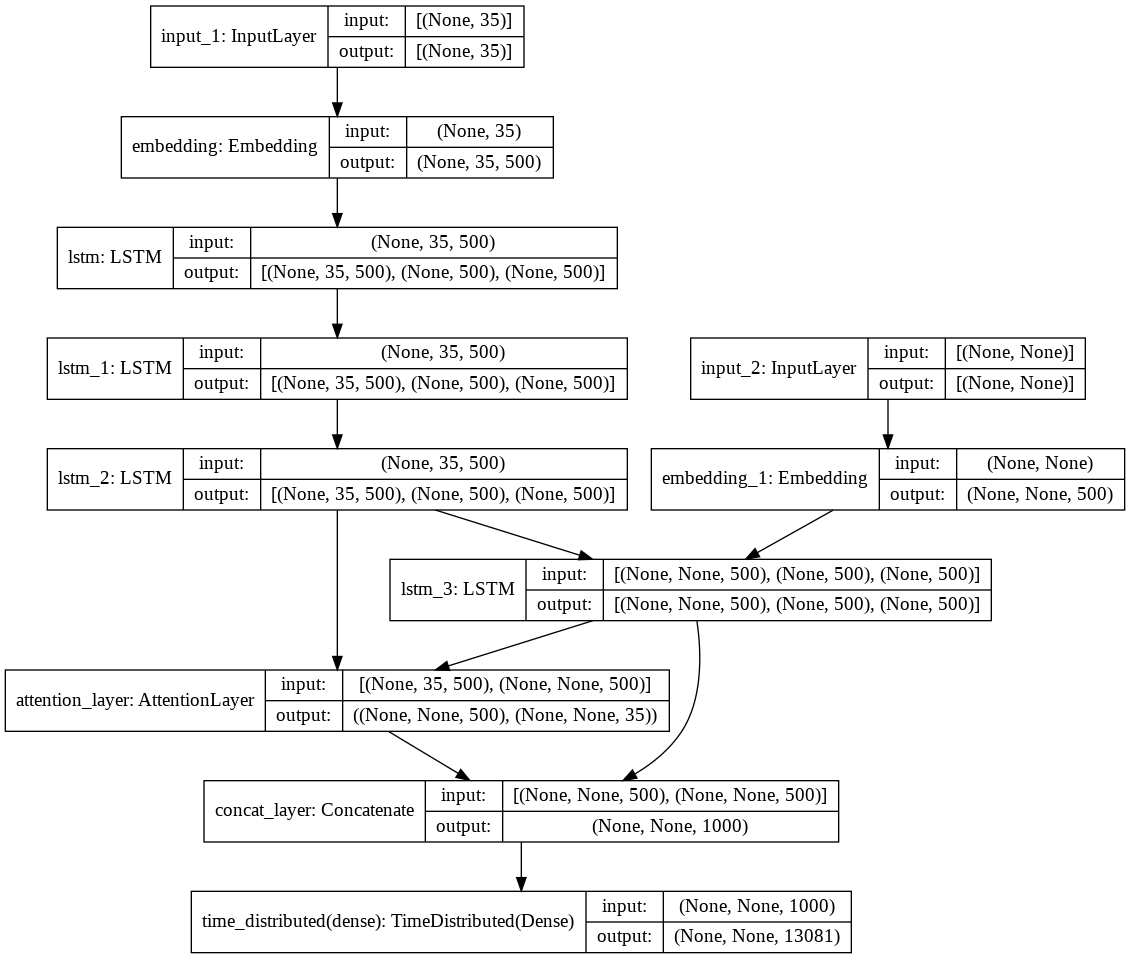

In [ ]:
plot_model(model, to_file='train_model.png', show_shapes=True)


In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:],
                    epochs=50,
                    callbacks=[es],
                    batch_size=512,
                    validation_data = ([X_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/50
73/73 [==============================] - 188s 3s/step - loss: 0.7817 - accuracy: 0.8834 - val_loss: 0.7114 - val_accuracy: 0.8902


In [ ]:
model_json = model.to_json()
with open("NMT_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("NMT_model_weight.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# loading the model architecture and asigning the weights
json_file = open('NMT_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json, custom_objects={'AttentionLayer': AttentionLayer})
# load weights into new model
model_loaded.load_weights("NMT_model_weight.h5")

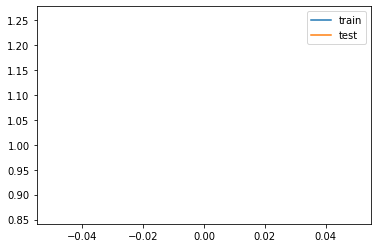

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
with open('NMT_Etokenizer.pkl','rb') as f:
  vocab_size_source, Eword2index, englishTokenizer = pkl.load(f)

with open('NMT_Mtokenizer.pkl', 'rb') as f:
  vocab_size_target, Mword2index, marathiTokenizer = pkl.load(f)

with open('NMT_data.pkl','rb') as f:
  X_train, y_train, X_test, y_test = pkl.load(f)

In [ ]:
Eindex2word = englishTokenizer.index_word
Mindex2word = marathiTokenizer.index_word

In [ ]:
model_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 500)      2757500     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 35, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
latent_dim=500
# encoder inference
encoder_inputs = model_loaded.input[0]  #loading encoder_inputs
encoder_outputs, state_h, state_c = model_loaded.layers[6].output #loading encoder_outputs

print(encoder_outputs.shape)

encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(37,latent_dim))

# Get the embeddings of the decoder sequence
decoder_inputs = model_loaded.layers[3].output

print(decoder_inputs.shape)
dec_emb_layer = model_loaded.layers[5]

dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_lstm = model_loaded.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_layer = model_loaded.layers[8]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])

concate = model_loaded.layers[9]
decoder_inf_concat = concate([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_dense = model_loaded.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

(None, 35, 500)
(None, None)


In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = Mword2index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
          break
        else:
          sampled_token = Mindex2word[sampled_token_index]

          if(sampled_token!='end'):
              decoded_sentence += ' '+sampled_token

              # Exit condition: either hit max length or find stop word.
              if (sampled_token == 'end' or len(decoded_sentence.split()) >= (26-1)):
                  stop_condition = True

          # Update the target sequence (of length 1).
          target_seq = np.zeros((1,1))
          target_seq[0, 0] = sampled_token_index

          # Update internal states
          e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=Mword2index['start']) and i!=Mword2index['end']):
        newString=newString+Mindex2word[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+Eindex2word[i]+' '
    return newString

In [ ]:
for i in range(1):

  print("Review:",seq2text(X_test[i]))
  print("Original summary:",seq2summary(y_test[i]))
  print("Predicted summary:",decode_sequence(X_test[i].reshape(1,35)))
  print("\n")

In [ ]:
print('Bleu-1: 0.767865')
print('Bleu-2: 0.635918')
print('Bleu-3: 0.492749')
print('Bleu-4: 0.335698')

Bleu-1: 0.767865
Bleu-2: 0.635918
Bleu-3: 0.492749
Bleu-4: 0.335698
